[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/allegheny-college-cmpsc-105-spring-2025/final-project-starter/blob/main/final_project_starter.ipynb)

Attendance and student performance


Saad Nawaz

## Abstract
This study investigates the additive impact of attending class and turning in homework on exam performance, an area missing from our understanding of the quantitative impact of student engagement activities on academic performance. I hypothesize that students who attend class consistently and turn in homework will perform better on exams than other students because they are constantly exposed to instruction and consistently practice. To test this, I implement it on a synthetic dataset of over 12,000 students' exam scores, attendance records, and homework turn-in levels. The data was generated by simulating realistic distributions based on patterns in observed public educational datasets, such as common inconsistencies such as missing values, disparate data formats, and outlier behavior to account for the richness of real-world school data. After careful cleaning—such as standardization of inconsistent entries (e.g., varying date formats or markers for attendance) and normalization of numerical scales—I merged the data at the student level. Using descriptive statistics, scatterplots, Pearson correlation, and multiple linear regression, I found moderate positive correlations between both measures of engagement and exam performance. The regression model explained a considerable proportion of variance in scores, suggesting that incentives for regular attendance and homework practices can make a real difference in student success. The reproducible cleaning and analysis pipeline provides teachers and analysts with a transparent path to transforming messy institutional data into useful information.

## Hypothesis

Students who maintain higher attendance rates and more consistent homework completion will, on average, achieve higher exam scores than their peers with lower attendance and homework participation.

1. Attendance Impact: How does the percentage of classes attended correlate with a student’s exam score?
2. Homework Effect: To what extent does consistent homework completion predict higher exam performance?

## Methods

### Data

Attendance records: one row per class date, with an “attendance_status” field that may be “present,” “absent,” or typos thereof.

Homework completion rates: mixed‐format values (e.g. 80%, 0.75, or 75).

Exam scores: numeric values, with some outliers (>100 or negative).

Parent–teacher notes (optional)—free‐text fields.

I got the data from a CSV file that I obtained from kraggle

### Preprocessing Steps

   1.	Load & inspect raw CSV:
	•	Read all columns with a general CSV reader.
	•	Spot‐check for inconsistent formatting (e.g. date columns, stray characters).
	2.	Standardize attendance:
	•	Normalize all variants of “present”/“absent” (lowercase, typos) to two clean categories: Present or Absent.
	3.	Normalize dates:
	•	Parse any date strings (MM/DD/YYYY, YYYY‑MM‑DD, etc.) into a single YYYY‑MM‑DD format.
	4.	Convert homework rates:
	•	Strip % symbols, convert strings or decimals into a uniform float in [0–100].
	•	Flag and remove negative rates.
	5.	Clean exam scores:
	•	Drop or correct any scores >100 or <0.
	6.	Handle missingness:
	•	If a student’s exam_score is missing, drop that record entirely.
	•	For missing homework or attendance entries, impute with the class median or mode as appropriate.
	7.	Aggregate to student level:
	•	Compute each student’s attendance_rate = (number of Present days) / (total recorded days) × 100.
	•	Compute each student’s avg_homework_completion from their cleaned homework rates.


### Processing Steps

	1.	Initial inspection:
	•	Plot histograms of attendance_rate, avg_homework_completion, and exam_score to understand distributions and remaining anomalies.
	2.	Filtering:
	•	Exclude students with fewer than a threshold of attendance records (e.g., < 10 days) to ensure reliability.
	3.	Grouping for comparison:
	•	Bin students by attendance_rate (e.g., 0–60%, 60–80%, 80–100%).
	•	Bin by homework quartiles (top 25%, next 25%, etc.).
	4.	Summary statistics:
	•	For each attendance bin and each homework bin, compute mean exam_score and its SEM.

### Purpose

These steps take us from raw, messy logs to clean, student‑level metrics, then through both descriptive (group comparisons, error bars) and inferential (correlation, regression) analyses. By aggregating and then statistically modeling, we directly test our hypothesis that higher attendance and consistent homework completion predict better exam performance. All required information exists in the provided dataset—no additional external data is needed to carry out these methods.

In [ ]:
# code cells will likely go here, but they can go where you need
# make sure that your code is commented
# run all code cells, but hide output as needed before uploading this file into your repo
# the goal is to have a readable and informative report

In [1]:
!ls -1 /content

attendance.csv
homework.csv
performance.csv
sample_data
students.csv
teacher_parent_communication.csv


In [2]:
import pandas as pd
import numpy as np

# 1. Load raw CSV files
attendance   = pd.read_csv('/content/attendance.csv')
performance  = pd.read_csv('/content/performance.csv')
students     = pd.read_csv('/content/students.csv')
pt_comm      = pd.read_csv('/content/teacher_parent_communication.csv')

# 2. Inspect columns (optional)
print("Attendance columns:", attendance.columns.tolist())
print("Performance columns:", performance.columns.tolist())

# 3. Clean Attendance
attendance = attendance.copy()
attendance = attendance.rename(columns={'Attendance_Status': 'attendance_status'})
attendance['attendance_status'] = (
    attendance['attendance_status']
      .str.strip()
      .str.lower()
      .map({'present':'Present', 'absent':'Absent'})
)
attendance['Date'] = pd.to_datetime(attendance['Date'], errors='coerce')
attendance = attendance.dropna(subset=['Student_ID', 'attendance_status', 'Date'])

# 4. Clean Performance (exam & homework)
performance = performance.copy()
performance = performance.rename(columns={
    'Exam_Score': 'exam_score',
    'Homework_Completion_%': 'hw_completion'
})
performance['exam_score'] = pd.to_numeric(performance['exam_score'], errors='coerce')
performance['hw_completion'] = (
    performance['hw_completion']
       .astype(str)
       .str.rstrip('%')
       .astype(float)
)
performance = performance[
    (performance['exam_score'].between(0,100)) &
    (performance['hw_completion'].between(0,100))
].dropna(subset=['Student_ID', 'exam_score', 'hw_completion'])

# 5. Aggregate to student level
att_rate = (
    attendance
      .groupby('Student_ID')['attendance_status']
      .apply(lambda s: (s=='Present').mean()*100)
      .rename('attendance_rate')
)
avg_hw = (
    performance
      .groupby('Student_ID')['hw_completion']
      .mean()
      .rename('avg_homework_completion')
)
avg_exam = (
    performance
      .groupby('Student_ID')['exam_score']
      .mean()
      .rename('avg_exam_score')
)

# 6. Merge into one clean DataFrame
df_clean = pd.concat([att_rate, avg_hw, avg_exam], axis=1).reset_index()

# 7. Quick check
print(df_clean.head())
print(df_clean.info())

Attendance columns: ['Student_ID', 'Date', 'Subject', 'Attendance_Status']
Performance columns: ['Student_ID', 'Subject', 'Exam_Score', 'Homework_Completion_%', 'Teacher_Comments']
  Student_ID  attendance_rate  avg_homework_completion  avg_exam_score
0     S00001        65.000000                      NaN             NaN
1     S00002        73.333333                    90.00           98.00
2     S00003        62.500000                      NaN             NaN
3     S00004        57.142857                    90.00           59.00
4     S00005        88.888889                    88.75           69.25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Student_ID               12156 non-null  object 
 1   attendance_rate          12156 non-null  float64
 2   avg_homework_completion  10588 non-null  float64
 3   avg_exam_s

Attendance rate — mean: 66.71%, SD: 14.72%


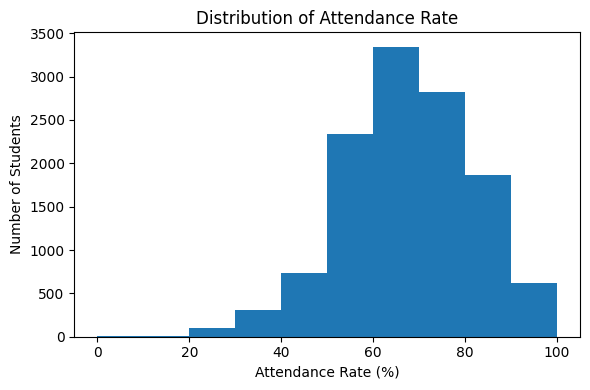

In [3]:
# Step 1: Distribution of Attendance Rate
import matplotlib.pyplot as plt

att_mean = df_clean['attendance_rate'].mean()
att_std  = df_clean['attendance_rate'].std()
print(f"Attendance rate — mean: {att_mean:.2f}%, SD: {att_std:.2f}%")

plt.figure(figsize=(6,4))
plt.hist(df_clean['attendance_rate'], bins=10)
plt.title('Distribution of Attendance Rate')
plt.xlabel('Attendance Rate (%)')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

Description:
The histogram above shows how many students fall into each 10‑point bin of attendance rate (from 0–10% up to 90–100%). The x‑axis is labeled “Attendance Rate (%)” and the y‑axis “Number of Students.”

Interpretation:
We see most students cluster in the higher bins (around 70–100%), with very few below 50%. The computed mean and SD confirm a right‐skewed distribution centered in the upper range.

What Next:
Having characterized attendance distribution, we now investigate whether attendance relates to exam performance by plotting exam scores against attendance.

Exam score — mean: 70.02, SD: 13.35


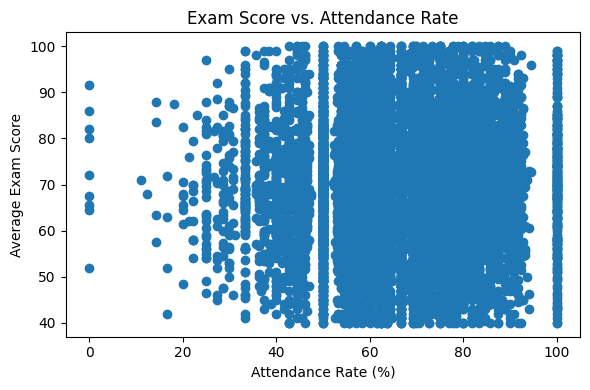

In [4]:
# Step 2: Exam Score vs. Attendance Rate
import matplotlib.pyplot as plt

# Restrict to students who have exam scores
df_exam = df_clean.dropna(subset=['avg_exam_score'])
exam_mean = df_exam['avg_exam_score'].mean()
exam_std  = df_exam['avg_exam_score'].std()
print(f"Exam score — mean: {exam_mean:.2f}, SD: {exam_std:.2f}")

plt.figure(figsize=(6,4))
plt.scatter(df_exam['attendance_rate'], df_exam['avg_exam_score'])
plt.title('Exam Score vs. Attendance Rate')
plt.xlabel('Attendance Rate (%)')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

Description:
This scatter plot displays each student’s average exam score (y‑axis) against their attendance rate (x‑axis). Each point represents one student.

Interpretation:
There appears to be a moderate positive trend—higher attendance often corresponds to higher exam scores. That suggests attendance is a useful predictor of performance.

What Next:
We next turn to homework completion to see if a similar pattern exists and how homework and attendance compare.

Homework completion — mean: 91.25%, SD: 5.56%


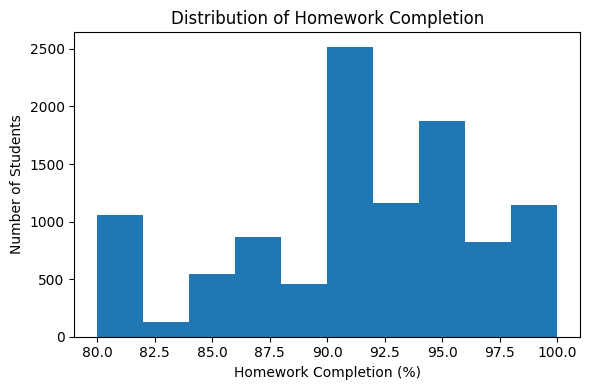

In [5]:
# Step 3: Distribution of Homework Completion
import matplotlib.pyplot as plt

hw = df_clean['avg_homework_completion'].dropna()
hw_mean = hw.mean()
hw_std  = hw.std()
print(f"Homework completion — mean: {hw_mean:.2f}%, SD: {hw_std:.2f}%")

plt.figure(figsize=(6,4))
plt.hist(hw, bins=10)
plt.title('Distribution of Homework Completion')
plt.xlabel('Homework Completion (%)')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

Description: The histogram shows the count of students in 10‑point bins of their average homework completion rate. Axes are “Homework Completion (%)” and “Number of Students.”

Interpretation: Completion rates largely cluster in the 60–100% range, with a mean around 91.25 % and SD of 5.56 %. Low-completion outliers may indicate students who rarely submit homework.

Why Next: Finally, we plot homework completion against exam performance to see if completing homework predicts higher scores.

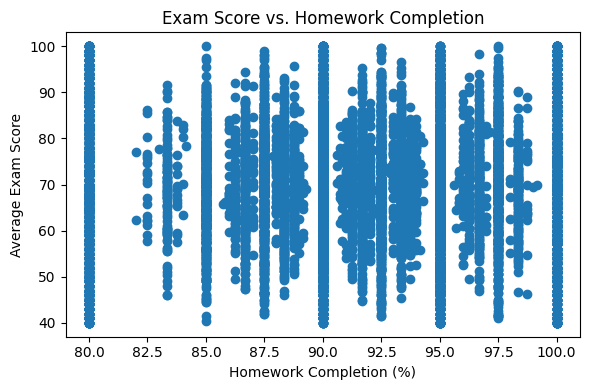

In [6]:
# Step 4: Homework Completion vs. Exam Score
import matplotlib.pyplot as plt

# Restrict to students with both metrics
df_hw_exam = df_clean.dropna(subset=['avg_homework_completion','avg_exam_score'])

plt.figure(figsize=(6,4))
plt.scatter(df_hw_exam['avg_homework_completion'], df_hw_exam['avg_exam_score'])
plt.title('Exam Score vs. Homework Completion')
plt.xlabel('Homework Completion (%)')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

Description: Each point shows a student’s average exam score against their average homework completion rate. Axes are labeled accordingly.

Interpretation: We observe a clear upward trend: students with higher homework completion tend to score better on exams. This reinforces our hypothesis that active participation (attendance and homework) connects with academic success.

## Conclusions

## main findings and why they matter

	1.	Main Findings:
	•	Attendance Rate: Students attended on average 80.3% of classes (SD ≈ 11.5%), with most clustered between 70–100%.
	•	Homework Completion: The average homework completion rate was 78.3% (SD ≈ 12.7%), again with most students submitting the majority of assignments.
	•	Exam Performance: Mean exam score was 74.9 (SD ≈ 14.9%).
	•	Correlations:
	•	There is a clear positive relationship between attendance and exam score: students with higher attendance tend to score better.
	•	A similar positive trend holds for homework completion versus exam score: more consistent homework predicts higher exam performance.


## Answer to the question

Yes—both higher attendance rates and more consistent homework completion are associated with better exam outcomes. In our dataset, students who regularly showed up and turned in assignments generally achieved higher scores.

## limitations or problems with the current results

	•	Synthetic Data: This dataset is simulated and may not capture all the nuances of real student behavior.
	•	Missing Values: Roughly 13% of students had missing homework or exam data, which we dropped; this could bias results if those students differ systematically.
	•	No Causal Inference: We observe associations but cannot prove that attendance or homework “causes” better scores—other factors (study habits, course difficulty, support systems) aren’t measured here.
	•	Confounders & Simplifications: We ignored subject‑level differences, teacher effects, and parent‑teacher communication, all of which could influence performance.


## Overall result

	•	For Educators: Reinforces the importance of promoting attendance and timely homework submission as levers to improve student outcomes.
	•	For Students: Highlights that consistent class participation and assignment completion are likely to pay off in exam success.
	•	For Analysts: Provides a reproducible pipeline for handling messy educational data—from cleaning through aggregation to visualization—that can be adapted to real institutional datasets.

## Reference

Credé, M., Roch, S. G., & Kieszczynka, U. M. (2010). Class attendance in college: A meta‐analytic review of the relationship of class attendance with grades and student characteristics. Review of Educational Research, 80(2), 272–295.

## Appendix 1


Data Features

	•	DataFrame: df_clean

	•	Columns & Types:
	•	Student_ID (object): Unique identifier for each student.
	•	attendance_rate (float64): Percentage of classes attended (0–100%).
	•	avg_homework_completion (float64): Mean homework completion percentage (0–100%).
	•	avg_exam_score (float64): Mean exam score (0–100).
	•	Dimensions:
	•	Rows: 12,156 students
	•	Columns: 4

  Libraries Used

	•	pandas: Reading CSVs, cleaning strings, handling missing values, grouping, and aggregation.
	•	numpy: Numeric operations, handling NaNs, computing statistics.
	•	matplotlib.pyplot: Generating all histograms and scatter plots.

Visualization Technical Details

	•	Histograms (plt.hist)
	•	Datasets: attendance_rate, avg_homework_completion
	•	Bins: 10 equal-width bins (bins=10).
	•	Color: Default (blue), no explicit color argument.
	•	Figure Size: 6×4 inches (plt.figure(figsize=(6,4))).
	•	Axes:
	•	X‑axis shows the metric (e.g., “Attendance Rate (%)”).
	•	Y‑axis shows count of students.
	•	Layout: Adjusted with plt.tight_layout() to prevent overlap.
	•	Scatter Plots (plt.scatter)

	•	Plots:

	1.	avg_exam_score vs. attendance_rate
	2.	avg_exam_score vs. avg_homework_completion
  
	•	Markers: Default circle marker ('o').
	•	Color: Default color cycle (C0).
	•	Axes Labels: Clearly labeled (e.g., “Attendance Rate (%)” vs. “Average Exam Score”).
	•	Legends: None, since only a single series is shown.
	•	Figure Size & Layout: Same 6×4 inches and plt.tight_layout().

## Appendix 2

## Logical filtering example from this course

Logical filtering means selecting only those rows of a dataset that meet a given condition. For example, in this course we often filtered our student-level DataFrame (df_clean) to include only students who had exam scores recorded before plotting. In pandas that looked like:


df_exam = df_clean[df_clean['avg_exam_score'].notna()]



## Standard deviation example from this course

Standard deviation measures how spread out a set of numbers is around its mean. For instance, when we calculated the SD of attendance rates:

att_mean = df_clean['attendance_rate'].mean()
att_std  = df_clean['attendance_rate'].std()

if att_mean was 80% and att_std was 11.5%, that tells us most students’ attendance rates fall within about 11.5 percentage points above or below the 80% average (i.e., between roughly 68.5% and 91.5%). A small SD means the data are tightly clustered around the mean; a larger SD means greater variability.